**Prediction of the value of dollar in Mexicans pesos using autoarima and Prophet**

In [227]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.ar_model import AR,ARResults

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA

In [228]:
df = pd.read_excel("csv/dolar_peso.xlsx", index_col=0,parse_dates=True,skiprows = 17)
data = df.copy()

In [229]:
data.head()

,SF63528
Fecha,
1954-04-19,0.0125
1954-04-20,0.0125
1954-04-21,0.0125
1954-04-22,0.0125
1954-04-23,0.0125


In [230]:
def preprocesing_data(df):
    df.rename(columns={'SF63528' : 'price'} , inplace= True)
    df = df.sort_index()
    df = df.asfreq('b')
    df.interpolate(inplace=True)
    mask = df.index.year >=2021
    df = df[mask]
                 
                 
    return df

In [231]:
data = preprocesing_data(data)
data.head()

,price
Fecha,
2021-01-01,19.8772
2021-01-04,19.8457
2021-01-05,19.9437
2021-01-06,19.7250
2021-01-07,19.9100


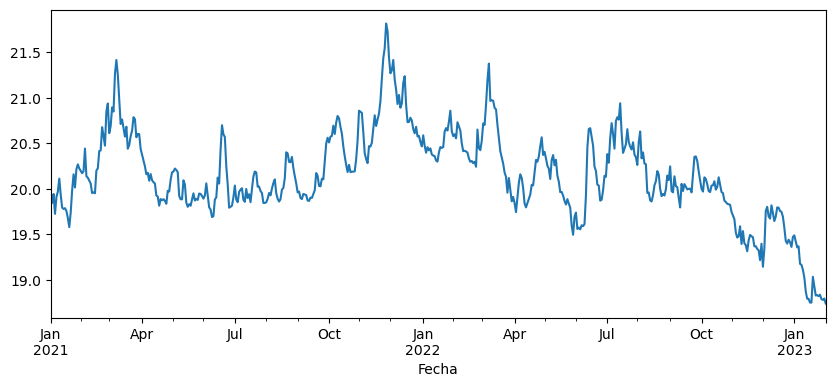

In [232]:
fig, axis = plt.subplots(1,1, figsize = (10,4))
data['price'].plot(ax = axis)
plt.show()

**Decompose the time serie into its trend, seasonality and residues**



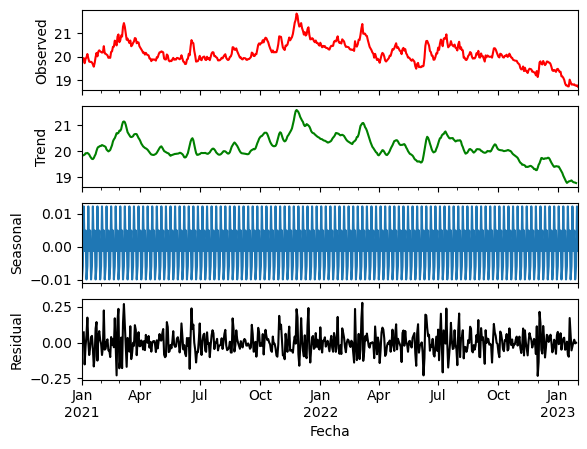

In [233]:
# ____Additive decomposition_____

dec_ts_add = seasonal_decompose(data.price, model="additive")

fig, axes = plt.subplots(4, 1, sharex = True)
dec_ts_add .observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
dec_ts_add.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
dec_ts_add .seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
dec_ts_add.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
plt.show()

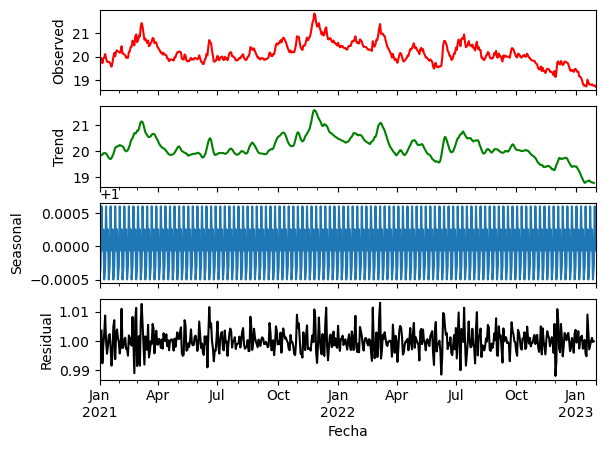

In [234]:
# ____Multiplicative decomposition_____

dec_ts_mul = seasonal_decompose(data.price, model="multiplicative")

fig, axes = plt.subplots(4, 1, sharex = True)
dec_ts_mul .observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
dec_ts_add.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
dec_ts_mul .seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
dec_ts_mul.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')
plt.show()

**Verify the stationarity**

In [235]:
test = adfuller(data['price'])[1]
if test > 0.05 :
    print("It's no stationary")
else:
    print("It's stationary")


It's no stationary


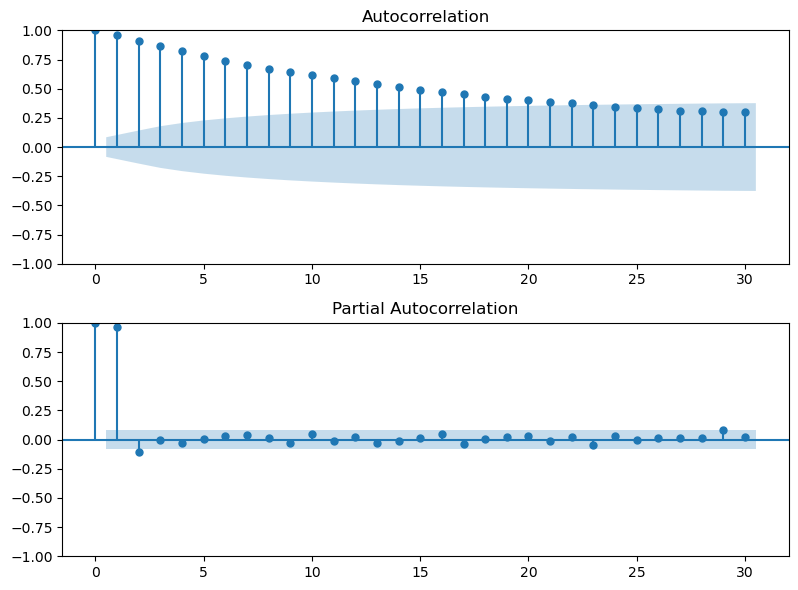

In [236]:
fig, axis = plt.subplots(2,1, figsize = (8,6))
plot_acf(data.price, lags=30, alpha = 0.05, ax = axis[0])
plot_pacf(data.price, lags=30, alpha = 0.05, ax = axis[1])
plt.tight_layout()

**Mean average**

In [237]:
data['DESadd12'] = ExponentialSmoothing(data['price'], trend = 'mul',seasonal = 'mul').fit().fittedvalues

model_mul = ExponentialSmoothing(data['price'], trend = 'mul',seasonal = 'mul', seasonal_periods=7).fit()
forescast_mul = model_mul.forecast(36)

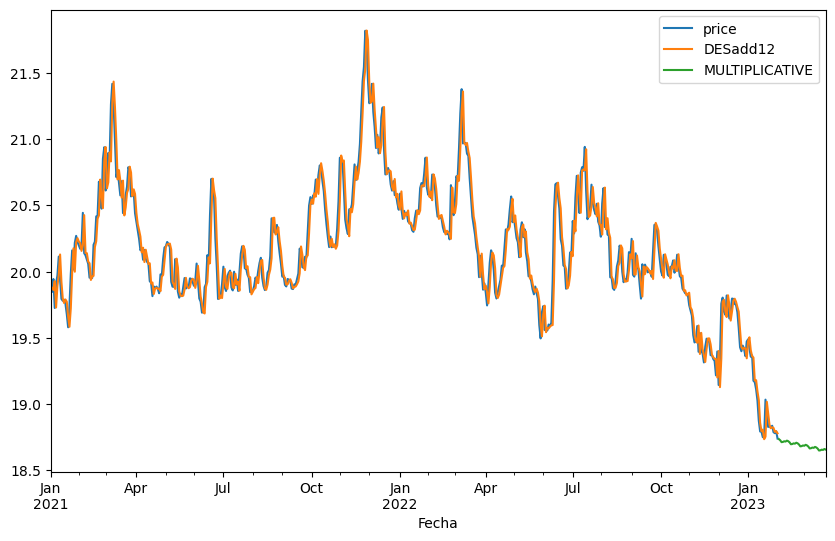

In [238]:
data.plot(figsize=(10,6))
forescast_mul.plot(label = 'MULTIPLICATIVE')
plt.legend()
plt.show()

In [239]:
datos = data['price'].copy().to_frame()

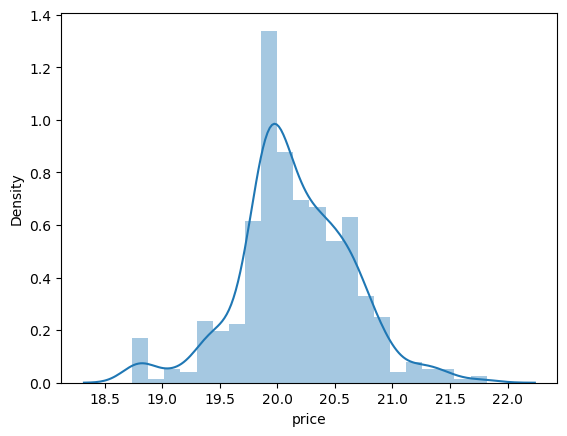

In [240]:
sns.distplot(datos['price'])
plt.show()

In [241]:
limit = int(0.2*len(datos))
train, test = datos.iloc[:-limit], datos.iloc[-limit:]

In [242]:
def test_stacionariedad(df):
    print("The p-value of the Dickie Fuller test is: ", adfuller(df.iloc[1:])[1])
    if adfuller(df.iloc[1:])[1] < 0.05:
        print('The time serie is stationary')
    else:
        print("The time serie is not stationary")
    fig, axis = plt.subplots(2,1, figsize = (8,6))
    plot_acf(df.iloc[1:], lags=30, alpha = 0.05, ax = axis[0], zero = False)
        
    plot_pacf(df.iloc[1:], lags=30, alpha = 0.05, ax = axis[1],zero = False,method=('ols'))
    plt.ylim(bottom=-0.3, top = 0.3)
    plt.tight_layout()

In [243]:
train.head()

,price
Fecha,
2021-01-01,19.8772
2021-01-04,19.8457
2021-01-05,19.9437
2021-01-06,19.7250
2021-01-07,19.9100


The p-value of the Dickie Fuller test is:  0.0016513000432705834
The time serie is stationary


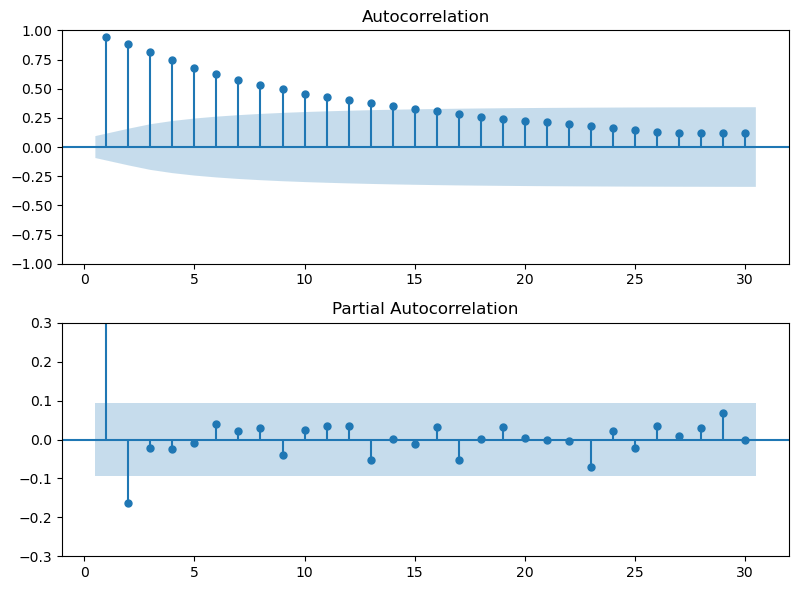

In [244]:
test_stacionariedad(train.price)

In [245]:
datos['diff_1'] = datos['price'].diff(1)

The p-value of the Dickie Fuller test is:  0.0
The time serie is stationary


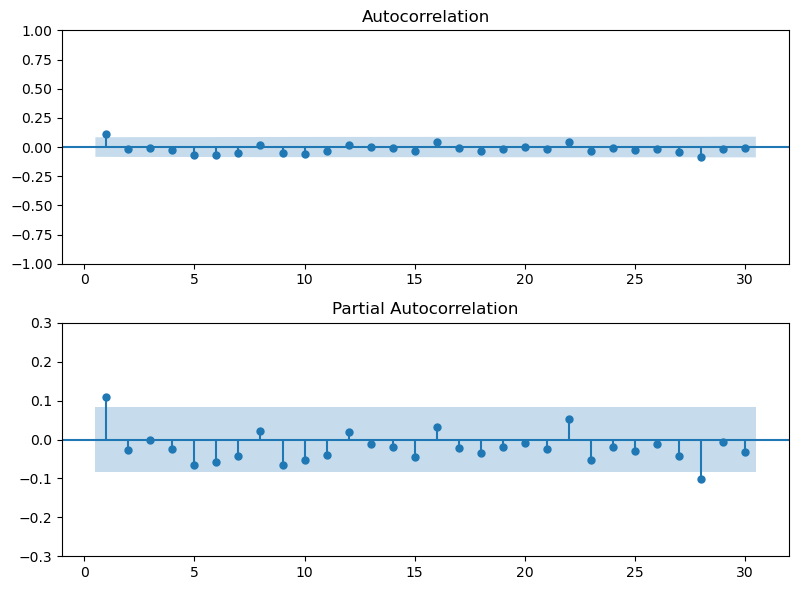

In [246]:
test_stacionariedad(datos['diff_1'])

In [247]:
from pmdarima import auto_arima

In [248]:
model = auto_arima(train['price'],
                      trace = True,
                      error_action = 'ignore',
                      suppress_warning = True,
                      seasonal = False,
                      maxiter=20
                      )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-533.400, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-533.568, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-539.300, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-539.357, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-535.566, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-537.373, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-537.377, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-535.373, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-541.357, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-539.374, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-539.376, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-541.300, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-537.372, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.413 seconds


In [249]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  436
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 272.678
Date:                Wed, 01 Feb 2023   AIC                           -541.357
Time:                        12:05:31   BIC                           -533.206
Sample:                             0   HQIC                          -538.140
                                - 436                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1342      0.043      3.115      0.002       0.050       0.219
sigma2         0.0167      0.001     18.062      0.000       0.015       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.76
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.21
Prob(H) (two-sided):                  0.57   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [250]:
train_pred = model.predict_in_sample(start=1, end=-1)
prediction, confint = model.predict(n_periods=limit, return_conf_int=True)

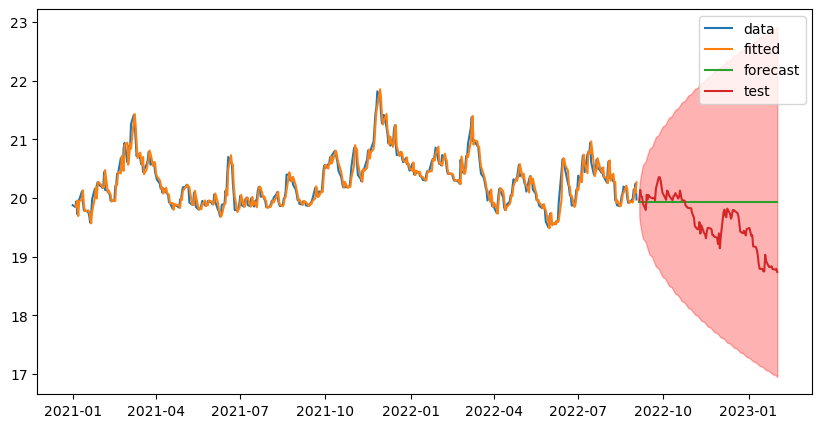

In [251]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(train.index, train['price'], label = 'data')
ax.plot(train.index[1:], train_pred, label = 'fitted')
ax.plot(test.index, prediction, label = 'forecast')
ax.plot(test.index, test['price'], label = 'test')

ax.fill_between(test.index, confint[:,0],confint[:,1], color = 'red', alpha = 0.3)
ax.legend();

*AS we can observe, the arima model is no able to forecast values similar to the test data. In contrast, the test data is inside the confident interval*

In [252]:
# Using the Prophet library to find out the confident interval
from prophet import Prophet

**Prophet**

In [253]:
data_p = ( data
            .reset_index()[['Fecha', 'price']]
            .rename(columns = {"Fecha": 'ds', 'price': 'y'})

)
data_p.head()

,ds,y
0,2021-01-01,19.8772
1,2021-01-04,19.8457
2,2021-01-05,19.9437
3,2021-01-06,19.7250
4,2021-01-07,19.9100


In [254]:
pd.plotting.register_matplotlib_converters()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(19387.0, 19408.0)

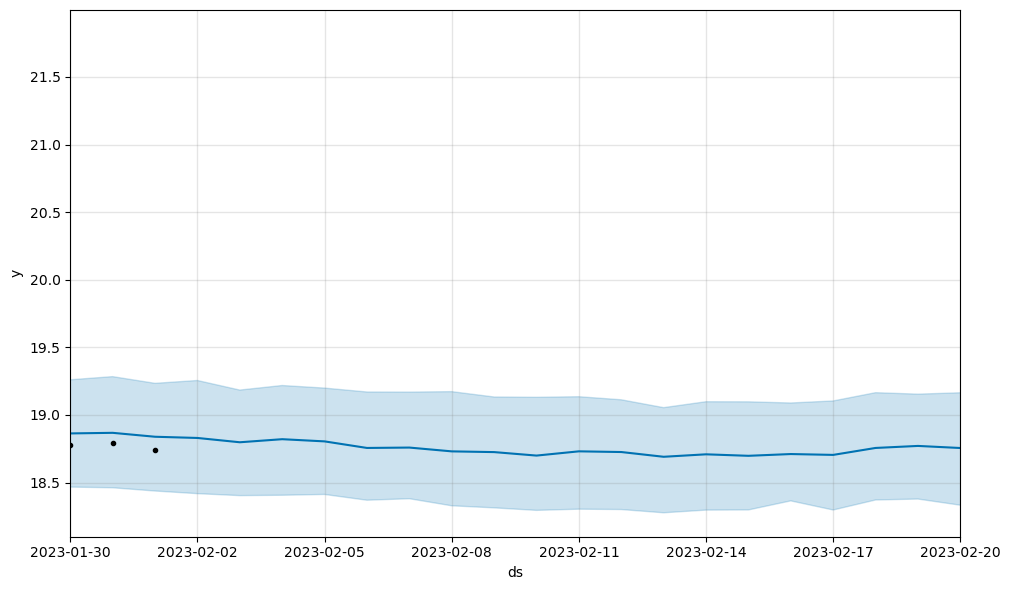

In [255]:
m = Prophet(interval_width=0.95)
m.fit(data_p)
future = m.make_future_dataframe(periods=30, freq = 'D')
forecast = m.predict(future)
m.plot(forecast)
plt.xlim(['2023-1-30','2023-02-20'])
